# References

* [CS231n: Convolutional Neural Networks for Visual Recognition 2017](http://cs231n.stanford.edu/2017/syllabus)
    - [cs231n 2017 assignment #1 kNN, SVM, SoftMax, two-layer network](https://cs231n.github.io/assignments2017/assignment1/)
    - [Training a Softmax Linear Classifier](https://cs231n.github.io/neural-networks-case-study)
* [ゼロから作る Deep Learning](https://github.com/oreilly-japan/deep-learning-from-scratch)
* [Mathematics for Machine Learning](https://mml-book.github.io/)

# Neural network 
Simple one layer neural network classifier. Mathjax formula not fully supported in github, hence the formulas get corrupted.

<img src="image/nn_diagram.png" align="left">

<img src="image/nn_functions.png" align="left">

# Setup

In [1]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple,
    Callable
)

### Python path
Python path setup to avoid the relative imports.

In [2]:
import sys
import os 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Package dependencies

In [3]:
import inspect
from functools import partial
import logging
import numpy as np
import matplotlib.pyplot as plt

### Jupyter notebook

In [4]:
#!conda install line_profile memory_profiler
%load_ext memory_profiler
%load_ext line_profiler

# Logging is enabled by calling logging.basicConfig
# logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
# Logger = logging.getLogger("neural_network")

### Matplotlib

In [5]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
plt.ion()

# Note: with notebook backend from the top, updating the plot line does not work...
%matplotlib notebook
# %matplotlib inline

### numpy

In [6]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=80) 

## Network geometry

In [7]:
N = 1    # Batch size
D = 3    # Number of features in the input data
M = 2    # Number of nodes in a layer

---

# Confiurations 

## X
X is to have been standardized. 

## T
Labels for data X.

### For One Hot Encoding labels
$
\begin{align*}
\overset{ (N,M) }{ T_{_{OHE}} } &= ( 
    \overset{ (M,) }{ T_{(n=0)} }, \; \dots \;, \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (N,M) }{ T_{_{OHE}} } = ( 
    \overset{ (M,) }{ T_{(n=0)} }, \dots , \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (M,) }{ T_{ _{OHE} (n)} } &= ( \overset{ () }{ t_{(n)(m=0)} }, \; \dots \;, \overset{ () }{ t_{(n)(m=M-1)} })
\end{align*}
$

### For index labels
$
\begin{align*}
\overset{ (N,) }{ T_{_{IDX}} } &= (\overset{ () }{ t_{(n=0)} }, \; \dots \;, \overset{ () }{ t_{(n=N-1)} }) \qquad \text {for index labels }
\end{align*}
$

## W
Weight parameters.

In [8]:
from common import (
    xavier,
    he,
    uniform
)

---

# Normalization Layer
Apply normalization or use batch normaliation.

---

# Matmul layer

In [9]:
from layer.matmul import Matmul

## Objective Function
$
\begin{align*}
\overset{ (N,M) }{ Y } 
&= 
\begin{bmatrix}
{ Y_{(n=0)} } \\
\vdots \\
{ Y_{(n)} } \\
\vdots \\
{ Y_{(n=N-1)} }
\end{bmatrix}
=
\overset{ (N,D) }{ X } \; @ \; \overset{ (D,M) }{ W^T }
\\
\\
\overset{ (M,) }{ Y_{(n)} } &= (y_{(n)(m=0)}, \; \dots, \; y_{(n)(m)},  \; \dots, \; y_{(n)(m=M-1)})
\\
\overset{ () }{ y_{(n)(m)} }
&= \overset{ (D,) }{ X_{(n)} } \cdot \overset{ (D,) }{ W_{(m)}^T }
= \sum\limits ^{D}_{d=0}  \overset{ () }{ x_{(n)(d)} } * \overset{ () }{ w_{(m)(d)} }
\\
_{(0 \le d \le D, \; 0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Gradient dL/dX

Impact on L by $dX$.

$
\begin{align*}
\overset { (N,D) }{ \frac {\partial L }{ \partial X } }
= \overset { (N,M) }{ \frac {\partial L}{\partial Y} }
@ \overset { (M,D) }{ W } 
\end{align*}
$
<img src="image/nn_back_propagation_dL_dX.png" align="left" />

## Gradient dL/dW.T
Impact on L by $dW^T$.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial W^T } }
= \overset { (D,N) }{ X^T } 
@ 
\overset { (N,M) }{ \frac {\partial L}{\partial Y} }
\end{align*}
$

<img src="image/nn_back_propagation_dL_dWT.png" align="left" />

---

# Activation layer

## Objective function
$
\begin{align*}
\overset{ (N,M) }{ A } &= 
activation \left( 
    \overset{ (N,M) }{ Y }  = 
    \begin{bmatrix}
    { Y_{(n=0)} } \\
    \vdots \\
    { Y_{(n)} } \\
    \vdots \\
    { Y_{(n=N-1)} }
    \end{bmatrix}
\right)
\\
\overset{ (M,) }{ A_{(n)} } 
&= activation \left( \overset{ (M,) }{ Y_{(n) }} \right)  \\
&= (a_{(n)(m=0)}, \; \dots, \; a_{(n)(m)},  \; \dots, \; a_{(n)(m=M-1)})
\\
\overset{ () }{ a_{(n)(m)} } &= activation \left( \overset{ () }{ y_{(n)(m)} } \right)
\quad _{(0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Gradient dL/dY

Impact on L by dY from the matmul layer.

$
\begin {align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial Y } }
= \overset { (N,M) }{ \frac {\partial L}{\partial A} } 
* 
\overset { (N,M) }{ \frac {\partial A}{\partial Y} }
\end {align*}
$

### For sigmoid activation

$
\begin{align*}
\overset {(N,M)}{\frac { \partial L }{ \partial Y} }
&= \frac { \partial A }{ \partial Y} * A * (1 - A)
\\
\frac { \partial y_{(n)(m)} } { \partial a_{(n)(m)} }
&= a_{(n)(m)} * (1 - a_{(n)(m)} )  \\ 
y_{(n)(m)} = sigmoid(a_{(n)(m)} )&=  \frac {1}{ 1 + exp(y_{(n)(m)})}
\end{align*}
$

### For ReLU activation

$
\begin{align*}
\frac { \partial a_{(n)(m)} }{ \partial y_{(n)(m)} }
&= 1 \quad y_{(n)(m)}  \gt 0 \\
&= 0 \quad y_{(n)(m)}  \le 0 \\
\end{align*}
$

---

# Softmax layer
$C_n$ is to prevent the overflow at $np.exp()$.

<img src="image/softmax.png" align="left" width=400/>

exp(x) can take all x values and produces a positive, which is required for log(y) that needs y > 0, hence fit-for-purpose to build a probability function.

<img src="image/exp.gif" align="left" width=250/>

Softmax and Cross Entropy Log Loss are combined as the gradient results in a simple form $P - T$.

In [10]:
from layer import CrossEntropyLogLoss
from common import softmax

lines = inspect.getsource(softmax)
print(lines)

def softmax(X: Union[np.ndarray, float]) -> Union[np.ndarray, float]:
    """Softmax P = exp(X) / sum(exp(X))
    Args:
        X: batch input data of shape (N,M).
            N: Batch size
            M: Number of nodes
    Returns:
        P: Probability of shape (N,M)
    """
    name = "softmax"
    assert isinstance(X, float) or (isinstance(X, np.ndarray) and X.dtype == float), \
        "X must be float or ndarray(dtype=float)"

    # --------------------------------------------------------------------------------
    # exp(x-c) to prevent the infinite exp(x) for a large value x, with c = max(x).
    # keepdims=True to be able to broadcast.
    # --------------------------------------------------------------------------------
    C = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - C)
    P = exp / np.sum(exp, axis=-1, keepdims=True)
    Logger.debug("%s: X %s exp %s P %s", name, X, exp, P)

    return P



## Objective function
$
\begin{align*}
\overset{ (N,1) }{ C } &= np.max\left( 
    \overset{ (N,M) }{ A }, \; axis=-1,  \; keepdim=True 
\right) \\
&=  
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ c_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ (N,M) }{ EXP } &= np.exp \left( \overset{ (N,M) }{ A } - \overset{ (N,1) }{ C } \right)
= np.exp \left(
    \begin{bmatrix}
    { A_{(n=0)} } - { C_{(n=0)} }\\
    \vdots \\
    { A_{(n)} }   - { C_{(n)} }\\
    \vdots \\
    { A_{(n=N-1)} } - { C_{(n=N-1)} }\\
    \end{bmatrix}
\right) 
\\
&= 
\begin{bmatrix}
    e_{(n=0)(m=0)}   & \dots      & e_{(n=0)(m=M-1)}   \\  
    \vdots           & e_{(n)(m)} & \vdots             \\
    e_{(n=N-1)(m=0)} & \dots      & e_{(n=N-1)(m=M-1)} 
\end{bmatrix} 
\\
\\
\overset{ (N,1) }{ S } &= \overset{ (N,1) }{ sum(EXP) } = np.sum \left( 
    \overset{ (N,M) }{ EXP }, \; axis=-1,  \; keepdim=True 
\right)
\\
&= 
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ s_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ () }{ s_{(n)} } &= \sum\limits ^{M-1}_{m=0} np.exp(\; a_{(n)(m)} - c_{(n)} \; )
\\
\\
\overset{ (N,M) }{ P } &= \overset{ (N,M) }{ EXP }  \;\; / \;\; \overset{ (N,1) }{ sum(EXP) } 
\\
\overset{ (N,) }{ P_{(n)} } &= (p_{(n)(m=0)}, \; \dots, \; p_{(n)(m)} , \; \dots, \; p_{(n)(m=M-1)})
\\
{ p_{(n)(m)} } 
&= \frac {np.exp \left( 
    { a_{(n)(m) } } - { c_{(n)} }) \right) 
}
{  
np.sum \left( 
    np.exp \left( 
        a_{(n)(m) } - c_{(n)}
    \right)
\right) 
}
\end{align*}
$

## Gradient dL/dA

Impact on L by dA from the activation layer.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{\partial A} }
= \overset { (N,M) }{ \frac {\partial L}{\partial P} }
* 
\overset { (N,M) }{ \frac {\partial P }{\partial A} } 
= 
\frac {1}{N} (P - T)
\end{align*}
$

$
Jacobian \; : \; f \circ g \rightarrow Jf \circ Jg
\\
\begin{align*}
\\
L &= f(\; p_{(n)(m=0)} \;) = f( \; g(\;  a_{(n)(m=0)} \; ) \; ) \quad : p = g(a) = softmax(a)
\\
\frac {\partial L} { \partial a_{(n)(m=0)} }
&= Jf(p) \circ Jg(a) 
=  \frac {\partial L} { \partial p_{(n)(m=0)} } * \frac {\partial  p_{(n)(m=0)}} { \partial a_{(n)(m=0)} }
\\
&= \frac {1}{N} \left(
 p_{(n)(m=0)} -t_{(n)(m=0)}
\right)
\end{align*}
$

### Gradient from cross entropy log loss

$
\begin{align*}
\frac { \partial L }{ \partial  p_{(n)(m=0)} }
&= \frac{-1}{N} t_{(n)(m=0)} * \frac {s_{(n)}}{e_{(n)(m=0)}}
\\
\frac { \partial L }{ \partial  p_{(n)(m=1)} } 
&= \frac{-1}{N} t_{(n)(m=1)} * \frac {s_{(n)}}{e_{(n)(m=1)}}
\end{align*}
$


###  Gradient $\frac { \partial  L } { \partial s^{-1}_{(n)} } $

$
\begin{align*}
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} } \\
p_{(n)(m=0)} &= f \circ g_{(m=0)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=0)} }
\rightarrow \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=0)}
\\
p_{(n)(m=1)} &= \frac {e_{(n)(m=1)} }{ s_{(n)} } \\
p_{(n)(m=1)} &= f \circ g_{(m=1)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=1)} }
\rightarrow \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=1)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    +
    \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\\
&= \sum\limits^{M-1}_{m=0} 
    e_{(n)(m)}  * \frac { \partial L }{ \partial  p_{(n)(m)} } 
\\
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
    \begin{bmatrix}
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } \\
    + \\
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
    \end{bmatrix}
\\
&= -s_{(n)}(\; t_{(n)(m=0)} + t_{(n)(m=1)} \;) \\
&= -s_{(n)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    + 
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\end{align*}
$

### Gradient $\frac {\partial L }{ \partial { s_{(n)} } } $

$
\begin{align*}
\frac {1} { s_{(n)} } &= s^{-1}_{(n)} \rightarrow
\frac { \partial { s^{-1}_{(n)} } } {\partial s_{(n)}} = \frac {-1}{s^{2}_{(n)}}
\\
\frac {\partial L }{ \partial { s_{(n)} } } 
&=
\frac {-1}{s^{2}_{(n)}} * 
\frac {\partial L}{ \partial s^{-1}_{(n)} } \\
&= \frac {1}{s_n}
\end{align*} \\
$



### Gradient $\frac {\partial L}{ \partial e_{(n)(m=0)} } $
$
\begin{align*}
s_{(n)} &= \sum\limits ^{M-1}_{m=0} e_{(n)(m)} \rightarrow 
\frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} = 1
\\
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} }\rightarrow 
\frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} = \frac {1}{s_{(n)}}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } 
&= \begin{bmatrix}  
    \frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} *  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
= \begin{bmatrix}  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\left[
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
    + 
    \frac {\partial L }{ \partial { s_{(n)} } } 
\right]
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\begin{bmatrix}  
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} }  \\
    +  \\
    \frac {\partial L }{ \partial s_{(n)} } 
\end{bmatrix} \\
&= \frac {-t_{(n)(m=0)}}{e_{(n)(m=0)} } + \frac {1}{s_{n}}
\end{align*}
$



### Gardient $\frac {\partial L}{ \partial a_{(n)(m=0)} } $

$
\begin{align*}
e_{(n)(m)} &= exp(\; a_{(n)(m)} \; ) \rightarrow \frac { \partial e_{(n)(m)} }{ \partial a_{(n)(m)} } = e_{(n)(m)} 
\\
e_{(n)(m=0)} &= exp(a_{(n)(m=0)}) \rightarrow \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } = e_{(n)(m=0)} 
\\
e_{(n)(m=1)} &= exp(a_{(n)(m=1)}) \\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&=   \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } * 
    \frac { \partial L }{ \partial e_{(n)(m=0)} } 
= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } 
\\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } \\
&= -t_{(n)(m=0)} + \frac { e_{(n)(m=0)} }{ s_{n} } \\
&= p_{(n)(m=0)} -t_{(n)(m=0)} 
\end{align*}
$

---

# Cross Entropy Log Loss

A probability distribution $P(x)$ can be represented with its entropy $E(x) = \sum\limits_{x}  \frac {p(x)}{log(p(x)} = - \sum\limits_{x} p(x) log(p(x))$. In the diagram, x: (0:dog, 1:cat, 2:fish, 3:bird) are labels and p(dog) is 0.5. When  a NN predicts an input x as a probability distribution $P(x)$, then the $E(x) = 1.75$. 

0. $p(dog)=\frac {1}{2}$
1. $p(cat)=\frac {1}{4}$
2. $p(fish)=\frac {1}{8}$
3. $p(bird)=\frac {1}{8}$

When the truth is that x is a dog, then the probability distribution of the truth $P(t)$ has the entropy $E(t) = 0$.

0. $p(dog)=1$
1. $p(cat)=0$
2. $p(fish)=0$
3. $p(bird)=0$

The difference E(x) - E(t) = E(x) = 1.75 can be used as the distance or the error of the prediction from the truth. Need to understand further but  the actuall loss function is $E(x) = -tlog(p(x)) = -log(p(x))$ where p(x) is the probability from the softmax for the correct label.


<img src="image/entropy.png" align="left" width=600/><br>

np.log() is ln based on the mathematical constant $e$ and its derivative $\frac {\partial log(x)}{\partial x} = \frac {1}{x}$.

* [Logarithm](https://en.wikipedia.org/wiki/Logarithm)


<img src="image/logarithm_plots.png" align="left" width=300/>

* [ML Grossary - Loss Functions](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

<img src="image/cross_entropy_log_loss.png" align="left" width=500/>

[cross_entropy_log_loss_input_combinations.xlsx](./common/cross_entropy_log_loss_input_combinations.xlsx)

In [11]:
from common import (
    cross_entropy_log_loss,
    OFFSET_LOG
)
lines = inspect.getsource(cross_entropy_log_loss)
print(lines)

def cross_entropy_log_loss(
        P: Union[np.ndarray, float],
        T: Union[np.ndarray, int],
        f: Callable = categorical_log_loss,
        offset: float = OFFSET_LOG
) -> np.ndarray:
    """Cross entropy log loss [ -t(n)(m) * log(p(n)(m)) ] for multi labels.
    Args:
        P: activation or probabilities from an activation function.
        T: labels
        f: Cross entropy log loss function f(P, T) where P is activation, T is label
        offset: small number to avoid np.inf by log(0) by log(0+offset)

    Returns:
        J: Loss value of shape (N,), a loss value per batch.

    NOTE:
        Handle only the label whose value is True. The reason not to use non-labels to
        calculate the loss is TBD.

        See transform_X_T for the format and shape of P and T.
    """
    name = "cross_entropy_log_loss"
    P, T = transform_X_T(P, T)
    if P.ndim == 0:
        assert False, "P.ndim needs (N,M) after transform_X_T(P, T)"
        # -----------------------------

## For label using One Hot Encoding (OHE)
For instance, if multi labels are (0,1,2,3,4) and each label is OHE, then the label for 2 is (0,0,1,0,0).   


### Product of matrix rows

There is no formal operation to calculate the dot products of the rows from two matrices, but to calculate the diagonal of the matlix multiplication that also calculate non-diagonals. To avoid calculating non-diagonals, use [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).

* [Name of matrix operation of ```[A[0] dot B[0], A[1] dot B[1] ]``` from 2x2 matrices A, B](https://math.stackexchange.com/questions/4010721/name-of-matrix-operation-of-a0-dot-b0-a1-dot-b1-from-2x2-matrices-a)

<img src="image/dot_products_of_matrix_rows.png" align="left"/>


In [12]:
import numpy as np

a = np.arange(6).reshape(2,3)
b = np.arange(0,-6,-1).reshape(2,3)
c = [
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
]
print(f"a is \n{a}")
print(f"b.T is \n{b.T}\n")
fmt=f"""c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is {c}\n
"""
print(fmt)

# Use einsum
e = np.einsum('ij,ji->i', a, b.T)
fmt="np.einsum('ij,ji->i', a, b.T)"
print(f"{fmt} is {e}")

a is 
[[0 1 2]
 [3 4 5]]
b.T is 
[[ 0 -3]
 [-1 -4]
 [-2 -5]]

c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is [-5, -50]


np.einsum('ij,ji->i', a, b.T) is [ -5 -50]


### Foward path (OHE)
$
\text{ for one hot encoding labels }
\\
\begin{align*}
\overset{ (N,) }{ J } &= - \sum\limits^{M-1}_{m=0} 
    \left[ \; \;  
        t_{(n)(m)} \;  * \;  np.log(p_{(n)(m)}) \;\;  
    \right]
\\
\overset{ () }{ j_{(n)} } &= \overset{ (M,) }{ T_{(n)} } \cdot \overset{ (M,) }{ P_{(n)} } 
\end{align*}
$

### Gradient dL/dP

Impact on L by the $dP$ from the softmax layer for one hot encoding labels.

$
\begin{align*}
\overset { (N,M) }{ \frac { \partial L }{ \partial P} }
&= \overset { (N,) }{ \frac { \partial L }{ \partial J} } * 
\overset { (N,M) }{ 
\left(
 - \frac { \partial T } { \partial P }
 \right) 
} 
= - \frac {1}{N }  \frac { \partial T } { \partial P }
\\
\frac {\partial L }{\partial p_{(n)(m=0)}} 
&= \frac {\partial L}{\partial j_{(n)}} * \frac {\partial j_{(n)}} {\partial p_{(n)(m=0)}} 
= \frac {1}{N} \frac { -t_{(n)(m=0)}}{ p_{(n)(m=0)} } 
=  \frac {1}{N} \left(
 -t_{(n)(m=0)} * \frac { s_{(n)} }{ e_{(n)(m=0)} }
\right)
\end{align*}
$

## For label using indexing 
For instance, if the multi labels are (0,1,2,3,4) then the index is 2 for the label 2. If the labels are (2,4,6,8,9), then the index is 3 for the label 8.  

Use LP to select the probabilities from P for the corresponding labels. For instance, if the label is 2 (hence the index is 2) for X(n=0), and 4 for X(n=3), then the numpy tuple indexing selects ```P[n=0][m=2]``` and ```P[n=3][m=4] ```.

```
P[
   (0, 3),
   (2, 4)
]
```

$
\text{ for index labels e.g. (5, 2, 0, 9, ...)}
\\
\\
\overset{ (N,) }{ J } = - np.sum(\; np.log(LP), \; axis = -1 \;) \\
LP = label\_probability = P \left[ \\
\quad ( \; 0, \; \dots, \;  {N-1}) , \\
\quad ( \; t_{(n=0)} \; , \dots , \; t_{(n=N-1)}) \\
\right]
\\
\\
$

---

# Total loss

## Forward path
$
\begin{align*}
\overset{ () }{ L } = \frac {1}{N} \sum\limits^{N-1}_{n=0} \overset{ () }{ j_{{(n)}} }
\end{align*}
$

## Gardient dL/dJ

Impact on L by $dJ$ from the cross entropy log loss layer.

$
\begin{align*}
\overset { (N,) }{ \frac {\partial L}{\partial J} }  &= \frac {1}{N} \overset{(N,)}{ones}
\\
\frac {\partial L}{\partial j_{(n)} } &= \frac {1}{N} 
\end{align*}
$

In [13]:
dJ = np.ones(N) / N
dJ

array([1.])

---


# Gradient check

* [two_layer_net.ipynb defines the lambda with parameter W which is redundant #254](https://github.com/cs231n/cs231n.github.io/issues/254)

The ```numerical_jacobian(f, X)``` returns ```J``` of the same shape with ```X```. It takes each element in ```x``` in ```X```, and calculate ```(f(x+h) and f(x-h))/2h```. For ```cross_entropy_logg_loss()```, the expected numerical gradient is ```gn = (-np.log(p+h+e) + -np.log(p-h+e)) / (2*h)``` for each element ```p``` in ```P```. 

In [14]:
from common import (
    numerical_jacobian,
    OFFSET_DELTA
)
lines = inspect.getsource(numerical_jacobian)
print(lines)

def numerical_jacobian(
        f: Callable[[np.ndarray], np.ndarray],
        X: Union[np.ndarray, float],
        delta: float = OFFSET_DELTA
) -> np.ndarray:
    """Calculate Jacobian matrix J numerically with (f(X+h) - f(X-h)) / 2h
    Jacobian matrix element Jpq = df/dXpq, the impact on J by the
    small difference to Xpq where p is row index and q is col index of J.

    Note:
        Beware limitations by the float storage size, e.g. loss of significance.
        https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/Contents/
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/02Numerics/Weaknesses/
        https://www.cise.ufl.edu/~mssz/CompOrg/CDA-arith.html

    Args:
        f: Y=f(X) where Y is a scalar or shape() array.
        X: input of shame (N, M), or (N,) or ()
        delta: small delta value to calculate the f value for X+/-h
    Returns:
        J: Jacobian matrix that has the same sh

In [15]:
# --------------------------------------------------------------------------------
# Example gradients for the cross entropy log loss -t*log(p).
# --------------------------------------------------------------------------------
p =0.86270721
h = OFFSET_DELTA
e = OFFSET_LOG

expected_gn = (-np.log(p+h+e) + np.log(p-h+e)) / (2*h)
actual_gn = (cross_entropy_log_loss(p+h, 1) - cross_entropy_log_loss(p-h, 1)) / (2*h)
print(f"Expected numerical gradient={expected_gn}")
print(f"Actual numerical gradient={actual_gn}")
print(f"Expected analytical gradient -T/P={-1 / (p+e)}")

Expected numerical gradient=-1.1591418103140683
Actual numerical gradient=[-1.15914181]
Expected analytical gradient -T/P=-1.1591418122503674


In [16]:
p = 0.50924298 
gn = (cross_entropy_log_loss(p+h, 1) - cross_entropy_log_loss(p-h, 1)) / (2*h)
gn

array([-1.9636992])

---

# Binary classification

Use Matmul and CrossEntropyLogLoss layers to build a binary classifer.

In [17]:
from common import (
    weights,
    transform_X_T,
    sigmoid_cross_entropy_log_loss,
    softmax_cross_entropy_log_loss
)
from data import (
    linear_separable
)
from optimizer import (
    Optimizer,
    SGD
)
from network import (
    train_binary_classifier
)
from drawing import (
    COLOR_LABELS,   # labels to classify outside/0/red or inside/1/green.
    plot_categorical_predictions
)

## X

Training data is two dimensional plots that can be linearly separable with a line whose normal is $(w1, w2)$ and point is $b=-w0/w2$. The line is written as $X \cdot W = 0$ where $W = (w0,w1,w2)$ and $X = (x0, x1, x2)$. $T$ are binary labels that tells if each plot is classfied as 0 or 1.

In [18]:
N = 500    # Number of plots
D = 3      # Number of features
from data import (
    linear_separable
)
X, T, V = linear_separable(d=D, n=N)
#print(f"X.shape {X.shape} T.shape {T.shape} W {V}")

### Classification goal

<IPython.core.display.Javascript object>


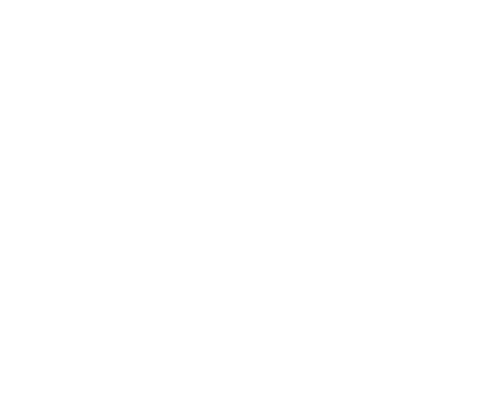

In [19]:
fig, ax = plt.subplots(figsize=(5,4))
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.set_title('Linarly seprable two dimensional plots')

ax.scatter(X[T==0, 1], X[T==0, 2], c='red')
ax.scatter(X[T==1, 1], X[T==1, 2], c='green')

# Hyperplace (X-b)V = 0 -> x1V1 + x2V2 - bV2 = 0
x = np.linspace(-3,3,100)
y = -(V[1] / V[2]) * x - (V[0] / V[2])
ax.plot(x, y)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid()

## Train binary classifiers
1. Sigmoid binary classifier
2. Softmax binary classifier

In [20]:
%matplotlib notebook

def draw_training(X, W, _ax=None, _fig=None, colors=['b']):
    w0 = W[0]
    w1 = W[1]
    w2 = W[2]
    
    #_ax.set_xlim(-3, 3)
    #_ax.set_ylim(-3, 3)
    #_ax.set_title(label=f"W: {W}")

    #_ax.scatter(X[T==0, 1], X[T==0, 2], c='red')
    #_ax.scatter(X[T==1, 1], X[T==1, 2], c='green')
    x = np.linspace(-3,3,100)
    if _ax.lines:
        for line in _ax.lines:
            line.set_xdata(x)
            y = -w1/w2 * x - w0 / w2
            line.set_ydata(y)
    else:
        for color in colors:
            y = -w1/w2 * x - w0 / w2
            _ax.plot(x, y, color)

    fig.canvas.draw()

    _x = np.linspace(-3,3,100)
    _y = -w1/w2 * x - w0 / w2
    _ax.plot(_x, _y, label='linear')  # Plot some data on the _axes.


<IPython.core.display.Javascript object>


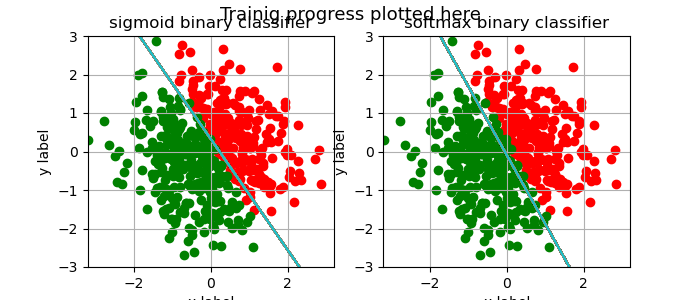

Text(0.5, 1.0, 'softmax binary classifier')

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))
for i in range(2):
    ax[i].scatter(X[T==0, 1], X[T==0, 2], c='red')
    ax[i].scatter(X[T==1, 1], X[T==1, 2], c='green')
    ax[i].set_xlabel('x label')
    ax[i].set_ylabel('y label')
    ax[i].axis('equal')
    ax[i].set_xlim(-3, 3)
    ax[i].set_ylim(-3, 3)
    ax[i].grid()

fig.suptitle('Trainig progress plotted here', fontsize=13)
ax[0].set_title("sigmoid binary classifier")
ax[1].set_title("softmax binary classifier")

## Sigmoid classifier training

Plots in the previous cell.

In [22]:
print(f"Train a sigmoid classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 100

M = 1
W = weights.xavier(M, D)    # Xavier initialization for Sigmoid
optimizer = SGD(lr=0.1)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[0])
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=sigmoid_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False,
    callback=draw
)

Train a sigmoid classifier to find optimal W (0.12700851678076866, -0.8785703802237388, -0.4604160332337093) for the boundary.
iteration 0 Loss 1.000942795394017
iteration 50 Loss 0.38639921636101837


array([[ 0.33311141, -1.47817628, -1.02381656]])

## softmax classifier training
Two class classification with softmax activation. 
Plots in the previous cell.

In [23]:
print(f"Train a softmax classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 200

M = 2                      
W = weights.he(M, D)
optimizer = SGD(lr=0.1)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[1])
ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False, 
    callback=draw
)

Train a softmax classifier to find optimal W (0.12700851678076866, -0.8785703802237388, -0.4604160332337093) for the boundary.
iteration 0 Loss 0.6166727273444044
iteration 50 Loss 0.2483639349443706
iteration 100 Loss 0.18993298055955246
iteration 150 Loss 0.16200157738897442


array([[ 0.07033189,  1.41191183,  0.79004954],
       [ 0.50745328, -1.79871736, -1.12364757]])

---

# Categorical Classification

Use Matmul and CrossEntropyLogLoss layers to classify M categorical data.

In [24]:
from common import (
    prediction_grid,
)
from data import (
    linear_separable_sectors,
)
from network import (
    train_matmul_relu_classifier
)

## Linearly separable multiple categories

### Data X and Label T
Training data to linearly classify into M categories and labels T.

In [25]:
print(f"Train a categorical classifier")
MAX_TEST_TIMES = 400
N = 300
D = 3      # Dimension
M = 3

rotation = np.radians(35)
# x0 = X[::,0] is the bias 1
X, T, B = linear_separable_sectors(n=N, d=D, m=M, r=2, rotation=rotation)

Train a categorical classifier


#### Plot X, T

<IPython.core.display.Javascript object>


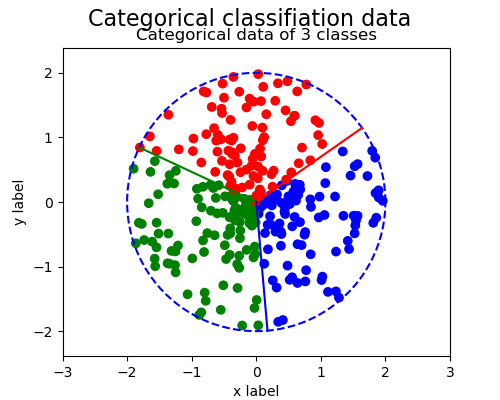

In [26]:
# Radius of a circle within which to place plots.
radius = 2   

# --------------------------------------------------------------------------------
# Plot area
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5,4))
for i in range(2):
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.axis('equal')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid()

ax.set_title(f"Categorical data of {M} classes")

# --------------------------------------------------------------------------------
# Cirle within which to place random plots.
# --------------------------------------------------------------------------------
r = np.linspace(0, 2 * np.pi, 100)
ax.plot(radius * np.cos(r), radius * np.sin(r), "b--")

# --------------------------------------------------------------------------------
# Classify plots (x, y) if inside the coverage sector
# labels to classify outside/0/red or inside/1/green.
# --------------------------------------------------------------------------------
Y = COLOR_LABELS[
    T
]

# --------------------------------------------------------------------------------
# Plot color-classified points.
# --------------------------------------------------------------------------------
ax.scatter(X[::,1], X[::,2], marker='o', color=Y)

# --------------------------------------------------------------------------------
# Plot sector bases
# --------------------------------------------------------------------------------
for i in range(B.shape[0]):
    ax.plot((0, radius * B[i, 0]), (0, radius * B[i, 1]), COLOR_LABELS[i])

# ax.legend()
fig.suptitle('Categorical classifiation data', fontsize=16)

plt.draw()
plt.show()


### Train on linearly separable multiple categories

In [27]:
W = weights.he(M, D)
optimizer = SGD(lr=0.1)

train_matmul_relu_classifier
# W = train_classifier(
W = train_matmul_relu_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

iteration 0 Loss 1.1145438356206971
iteration 50 Loss 0.9593016370646833
iteration 100 Loss 0.9303877418906268
iteration 150 Loss 0.9171390773352421
iteration 200 Loss 0.9093634571837658
iteration 250 Loss 0.9045010407311732
iteration 300 Loss 0.9010593961407187
iteration 350 Loss 0.8985534369264715


### Run predictions

Run preditions against the grid coordinates (x1, x2).
```
x1: X[:, 1].min() - 1 <= x1 <=  X[:, 1].max() + 1
x2: X[:, 2].min() - 1 <= x2 <=  X[:, 2].max() + 1
grid = np.meshgrid(x1, x2)

# np.argmax(scores) selets the highest score for each data point in X.
# e.g score[i] = [0.2, 8.2, 0.3], then np.argmax(scores[i]) selects index 1 as the prediction. 
# Then cluster of predition/label == 1 will form a contour.
sores = grid @ W.T
predictions = p.argmax(score, axis=1)
```

### Plot predictions

<IPython.core.display.Javascript object>


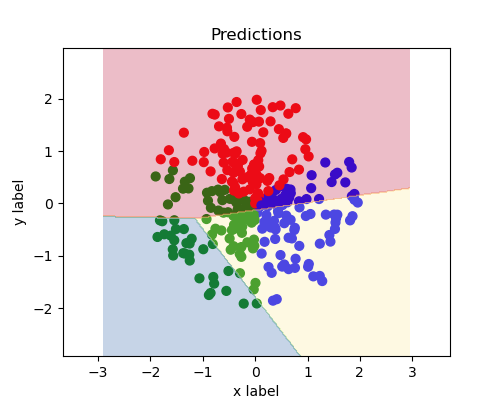

In [28]:
fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
ax.set_title("Predictions")
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)

x_grid, y_grid, predictions = prediction_grid(X, W)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

plt.show()

## Non-linear separable spiral data

### Data X and Label T
Training data to linearly classify into M categories and labels T.

In [29]:
from data import (
    set_in_a_radius,
    set_in_A_not_B,
    sets_of_circle_A_not_B
)
from common import (
    prediction_grid_2d
)
from network import (
    train_two_layer_classifier
)

<IPython.core.display.Javascript object>


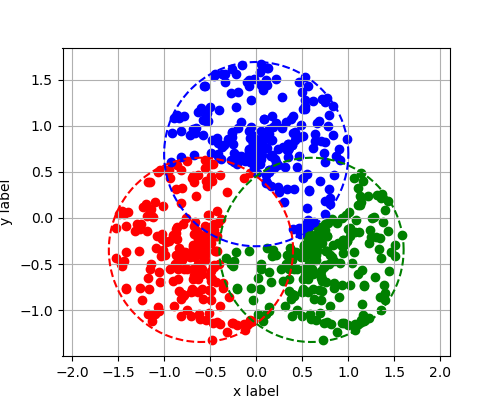

In [30]:
M = 3
__N = 300
radius = 1
circles, centres = sets_of_circle_A_not_B(radius=radius, ratio=1.2, m=M, n=__N)

fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
r = np.linspace(0, 2*np.pi, 100)

for i in range(M):
    circle = circles[i]
    if circle.size > 0:
        x = centres[i][0]
        y = centres[i][1]
        ax.scatter(circle[::, 0], circle[::, 1], color=COLOR_LABELS[i])
        ax.plot(
            x + radius * np.cos(r), 
            y + radius * np.sin(r), 
            linestyle='dashed', 
            color=COLOR_LABELS[i]
        )



In [31]:
X = np.vstack(
    [circles[i] for i in range(M)]
)

T = np.hstack(
    [np.full(circles[i].shape[0], i) for i in range(M)]
)
N = T.shape[0]
assert T.shape[0] == X.shape[0]

# Shuffle the data
indices = np.random.permutation(range(T.shape[0]))

X = X[indices]
X = np.c_[
    np.ones(X.shape[0]),
    X
]       # Add bias=1
T = T[indices]
Y = COLOR_LABELS[T]

### Train on non-linear separable spiral data

In [32]:
MAX_TEST_TIMES = 5000
D = 3
M1 = 100
W1 = weights.he(M1, D)
M2: int = 3                 # Number of categories to classify
W2 = weights.he(M2, M1)
optimizer = SGD(lr=0.5)

#X, T = transform_X_T(X, T)
W1, W2, objective, prediction = train_two_layer_classifier(
    N=N,
    D=D,
    X=X,
    T=T,
    M1=M1,
    W1=W1,
    M2=M2,
    W2=W2,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)


Expected dL/dW 
[[ 4.00273906e-03  1.41432822e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.93653852e-02  1.38914052e-02  1.91943051e-02  0.00000000e+00  0.00000000e+00  6.48607808e-03  2.85741066e-02  2.81099350e-06  2.63809076e-03  0.00000000e+00  0.00000000e+00  2.51532141e-02  1.16565622e-02  2.42752013e-04  1.13789819e-02  1.56312281e-05  0.00000000e+00  0.00000000e+00  1.60390908e-02  1.55787539e-03  1.07887665e-03  2.31159924e-03  2.59128622e-02  0.00000000e+00  1.29208584e-02  0.00000000e+00  3.53611430e-03  0.00000000e+00  1.40800042e-02  8.95001312e-04  5.27950771e-03  9.31207725e-03  6.08244973e-03  2.83480091e-02  2.28074202e-03  1.26418735e-03  1.34461191e-03  7.04044005e-05  2.26511010e-02  0.00000000e+00  4.09242961e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.95626395e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.37810806e-02  0.00000000e+00  3.76037068e-03  3.16333537e-03  1.41533345e-02  0.00000000e+00  0.00000000e+00  1.35767558e-02  4.531

Expected dL/dW 
[[ 5.74114912e-03 -6.58099828e-03 -3.09080328e-02]
 [-6.30612567e-03 -9.92969102e-03 -4.18154290e-03]
 [-9.39308718e-04  2.12051699e-04 -1.49933797e-03]
 [-6.77084271e-04  1.17142639e-03  2.42145717e-04]
 [ 5.44919171e-04 -4.33407624e-04  2.16982204e-04]
 [-1.48946230e-02 -1.70653666e-02 -3.16154555e-03]
 [ 8.03906217e-03 -3.12687942e-02 -6.12649569e-03]
 [-8.14250409e-03  1.24368777e-02 -3.10896740e-02]
 [-2.39892624e-02 -7.71116755e-04 -2.25363962e-02]
 [-1.46489155e-03  1.49458635e-03  1.67965393e-03]
 [-3.42134189e-03  3.12404301e-02 -6.12562810e-03]
 [-7.55227238e-03  7.02762425e-03  9.38656330e-03]
 [-9.72477668e-03  1.14872728e-02  9.60294148e-04]
 [-2.33587086e-03  5.70391851e-03  6.14746583e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.40742296e-03 -5.22276862e-04 -1.88042593e-03]
 [-6.50445482e-05 -1.79713898e-02  4.45876926e-03]
 [ 7.92414575e-03  8.32529613e-03 -3.43454292e-03]
 [ 3.09967650e-03 -5.14359305e-04  4.27399329e-03]
 [ 5.49582105e-

Expected dL/dW 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000

Expected dL/dW 
[[-8.25010293e-03 -4.51104659e-03 -1.59750432e-02]
 [-1.43261051e-02 -7.61790567e-03 -3.83959070e-03]
 [ 1.59765786e-04 -5.87102248e-04 -5.82238212e-04]
 [ 6.10264927e-04  4.62151892e-04  1.12993570e-03]
 [-2.68539372e-04  4.51193636e-04 -3.84593339e-04]
 [-2.68224510e-02 -1.84873085e-02 -3.67946132e-03]
 [-1.73202337e-02 -1.76000118e-02 -4.12720954e-03]
 [-1.55399288e-02  2.61205930e-03 -1.83832301e-02]
 [-1.27716388e-02 -2.79744936e-03 -1.24037151e-02]
 [-1.32623619e-03  1.51174847e-03  7.81515880e-05]
 [ 1.08119228e-02  1.20331483e-02 -1.20492016e-03]
 [-1.58230798e-03 -1.43629969e-03  5.12218311e-03]
 [-4.57747119e-04  1.77001669e-03  1.74167558e-03]
 [ 2.31416471e-03  1.91277753e-03  2.21642334e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.10400227e-04 -3.86062741e-04 -9.98154506e-04]
 [-1.10377573e-02 -1.21311583e-02  6.76097720e-04]
 [ 2.95588555e-03  2.43869158e-03 -1.68099257e-03]
 [ 3.78692869e-04 -1.22108935e-03  1.58468524e-03]
 [ 9.08888731e-

Expected dL/dW 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000

Expected dL/dW 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000

Expected dL/dW 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000

iteration 0 Loss 1.1241071357430432


Expected dL/dW 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000

iteration 100 Loss 0.45815249731849966
iteration 200 Loss 0.4429333720880284
iteration 300 Loss 0.4350525854148808
iteration 400 Loss 0.42968412795931515
iteration 500 Loss 0.4251851675108862
iteration 600 Loss 0.4217761837476514
iteration 700 Loss 0.4190495128046366
iteration 800 Loss 0.41668522825166804
iteration 900 Loss 0.4145793767675519
iteration 1000 Loss 0.4127082881862488
iteration 1100 Loss 0.4109640726324176
iteration 1200 Loss 0.4093502802263411
iteration 1300 Loss 0.40784168239033314
iteration 1400 Loss 0.4064464434009082
iteration 1500 Loss 0.40519691981729333
iteration 1600 Loss 0.4040714242079205
iteration 1700 Loss 0.40300528405551844
iteration 1800 Loss 0.4019777678390314
iteration 1900 Loss 0.4009831912913308
iteration 2000 Loss 0.40001860370435477
iteration 2100 Loss 0.3990782737641849
iteration 2200 Loss 0.39817217496681867
iteration 2300 Loss 0.39729045345803393
iteration 2400 Loss 0.39651790140000864
iteration 2500 Loss 0.3958114407550758
iteration 2600 Loss 0.39

Iteration [4181]: Loss[0.3798578036484177] has not improved from the previous [0.3798577658745306] for 1 times.
Iteration [4201]: Loss[0.37979121183401704] has not improved from the previous [0.37978980760216163] for 1 times.


iteration 4200 Loss 0.37978980760216163


Iteration [4281]: Loss[0.37953662083654177] has not improved from the previous [0.3795341651961546] for 1 times.


iteration 4300 Loss 0.3794763516038352


Iteration [4361]: Loss[0.3792945109755162] has not improved from the previous [0.37929234654924454] for 1 times.
Iteration [4401]: Loss[0.3791769810762579] has not improved from the previous [0.37917632141871765] for 1 times.


iteration 4400 Loss 0.37917632141871765


Iteration [4421]: Loss[0.3791204244297926] has not improved from the previous [0.379119725539833] for 1 times.


iteration 4500 Loss 0.37890005712389563
iteration 4600 Loss 0.3786357284684722
iteration 4700 Loss 0.378377224377264
iteration 4800 Loss 0.3781268681336173
iteration 4900 Loss 0.37787033256726527
iteration 5000 Loss 0.37762533770132306
iteration 5100 Loss 0.3773800319355499
iteration 5200 Loss 0.3771386019769656
iteration 5300 Loss 0.3769038736616387
iteration 5400 Loss 0.37667450106288414
iteration 5500 Loss 0.37645355961432714
iteration 5600 Loss 0.37623096165974096
iteration 5700 Loss 0.3760138698543496
iteration 5800 Loss 0.3758114625079422
iteration 5900 Loss 0.37561648380544405


### Plot predictions

<IPython.core.display.Javascript object>


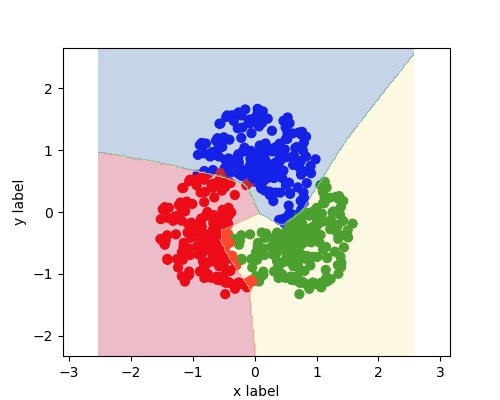

In [33]:
fig, ax = plt.subplots(figsize=(5,4)) 
x_min, x_max = X[:, 1].min(), X[:, 1].max()
y_min, y_max = X[:, 2].min(), X[:, 2].max()
Y = COLOR_LABELS[T]

x_grid, y_grid, predictions = prediction_grid_2d(x_min, x_max, y_min, y_max, prediction)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()